In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision import datasets
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from utils.BP_neural_utils import bp_neural as bp
from utils.BP_neural_utils import *

def save_parameters(file_name='parameters.npz',**kargs):
    parameters = {}
    for key,value in kargs.items():
        parameters[key] = value
    np.savez(file_name,**parameters)
    print('Save file:',file_name)

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

train_imgs = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_imgs = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

batch = 5000
train_imgs = train_imgs[:batch]
train_labels = train_labels[:batch]

In [5]:
a = bp_neural(train_imgs,train_labels,n_hidden=100)
a.normalize_images(inplace=True)
a.one_hot(inplace=True)
a.init_params()
a.node_info()
error = []

Train_images shape: (784, 5000)
Train_lables shape: (10, 5000)
Input layer nodes: 784
Hidden layer nodes: 100
Output layer nodes: 10
Activation function: softmax
A1 shape: (0,)
A2 shape: (0,)
Z1 shape: (0,)
Z2 shape: (0,)


100%|██████████| 500/500 [00:25<00:00, 19.71it/s]
c:\Users\Pan\Documents\User\Dierctory\Code\Example\BP_Neural_Network\utils\BP_neural_utils.py:62: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


Train_error: 0.08420000000000005
Test_error: 0.20730000000000004
save file: parameters.npz


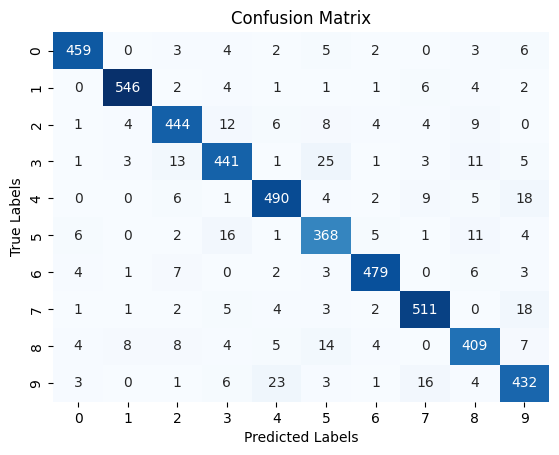

In [7]:
for i in tqdm(range(500)):
    a.front_prop()
    a.back_prop()
    a.update_params(lr=0.3)
    error.append(1-a.accuracy())
print(f'Train_error: {1-a.accuracy()}')
print(f'Test_error: {1-(a.predict(test_imgs.reshape(test_imgs.shape[0],-1).T) == test_labels).mean()}')
save_parameters('parameters.npz',w1=a.w1,w2=a.w2,b1=a.b1,b2=a.b2)
a.plot()

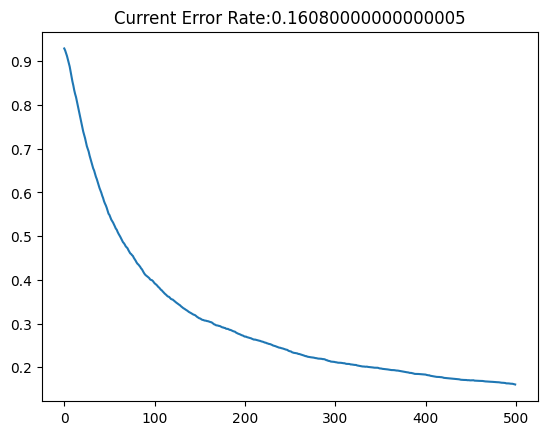

In [79]:
plt.title(f'Current Error Rate:{1-a.accuracy()}')
plt.plot(error)

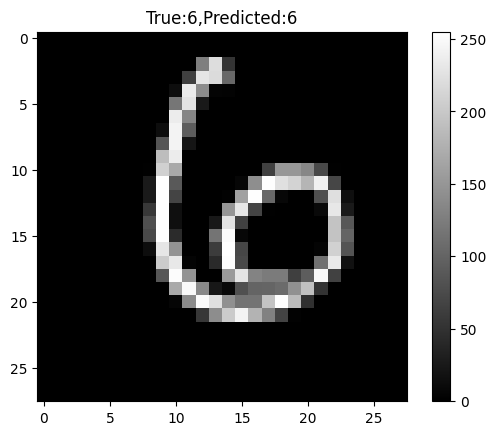

In [83]:
index = 100
num = a.predict(test_imgs[index].reshape(1,-1).T)
plt.title(f'True:{test_labels[index]},Predicted:{num[0]}')
plt.imshow(test_imgs[index],cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
parameters = np.load('parameters.npz')
a.w1 = parameters['w1']
a.b1 = parameters['b1']
a.w2 = parameters['w2']
a.b2 = parameters['b2']

In [87]:
# opencv 手绘预测
import cv2

def draw(event,x,y,flags,param):
    global ix,iy,drawing
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix,iy = x,y
    elif event ==cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            cv2.circle(m_img,(x,y),25,(255,255,255),-1)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
    elif event == cv2.EVENT_RBUTTONDOWN:
        m_img[:,:] = 0

m_img = np.zeros((512,512,3),dtype=np.uint8)
cv2.namedWindow('image')
cv2.setMouseCallback('image',draw)
drawing = False

while True:
    gm_img = cv2.cvtColor(m_img,cv2.COLOR_BGR2GRAY)
    cv2.imshow('image',gm_img)
    res = cv2.resize(gm_img,(28,28),interpolation=cv2.INTER_AREA)
    # cv2.imshow('res',res)
    res = res.reshape(1,28*28)
    cv2.setWindowTitle('image','predicted num:' + str(a.predict(res.T)[0]))
    if cv2.waitKey(1) & 0xFF == 27:
        break

cv2.destroyAllWindows()

c:\Users\Pan\Documents\User\Dierctory\Code\Example\BP_Neural_Network\utils\BP_neural_utils.py:62: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


In [86]:
cv2.destroyAllWindows()